In this file we will load and run a trained model.

In [1]:
from infopath.model_loader import load_model_and_optimizer
from infopath.config import load_training_opt
import matplotlib.pyplot as plt
import torch 

log_path = "log_dir/trained_models/main_model/"
opt = load_training_opt(log_path)
opt.log_path = log_path
opt.device = "cpu"
model = load_model_and_optimizer(opt, reload=True, last_best="last")[0]

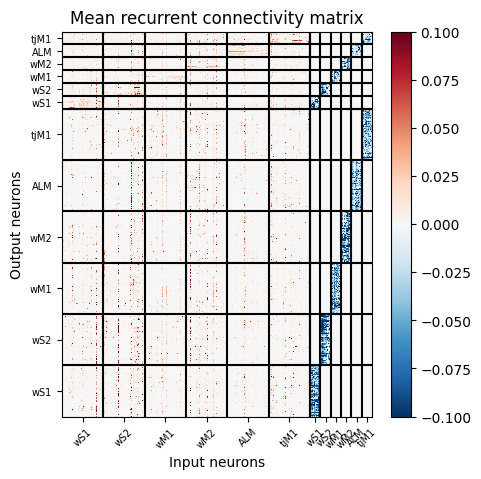

In [2]:
# Plot the mean recurrent connectivity matrix 
w_rec = model.rsnn._w_rec.detach().mean(0)
# Here all weights are positive, because the sign is calculated when we compute the currents.
#   That's why we multiply by -1 to have inhibitory weights in blue.
sign_mask = torch.ones(w_rec.shape)
sign_mask[:, -model.rsnn.inhibitory:] = -1 
w_rec = w_rec * sign_mask

w_rec = w_rec.numpy()
plt.figure(figsize=(5, 5))
plt.pcolormesh(w_rec, cmap="RdBu_r", vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.title("Mean recurrent connectivity matrix")
plt.xlabel("Input neurons")
plt.ylabel("Output neurons")
# lines separate the different populations, first 1200 neurons are excitatory and last 300 are inhibitory
for i in range(200, 1400, 200):
    plt.axvline(i, color="k")
    plt.axhline(i, color="k")
for i in range(1200, 1500, 50):
    plt.axvline(i, color="k")
    plt.axhline(i, color="k")
# put the name of areas as a x label on the plot {wS1, wS2, wM1, wM2, ALM, tjM1}
xticks = [100, 300, 500, 700, 900, 1100, 1225, 1275, 1325, 1375, 1425, 1475]
xlabels = ["wS1", "wS2", "wM1", "wM2", "ALM", "tjM1"] * 2
plt.xticks(xticks, xlabels, rotation=45, fontsize=7)
plt.yticks(xticks, xlabels, fontsize=7)
plt.savefig("weights.png", dpi=300, bbox_inches="tight")


In [3]:
with torch.no_grad():
    stims = torch.randint(2, size=(10,)) # binary vector of conditions (absence or presence of whisker stimulation)
    spikes, voltages, jaw, state = model(stims) # generation of the input spikes and simulation of the RSNN

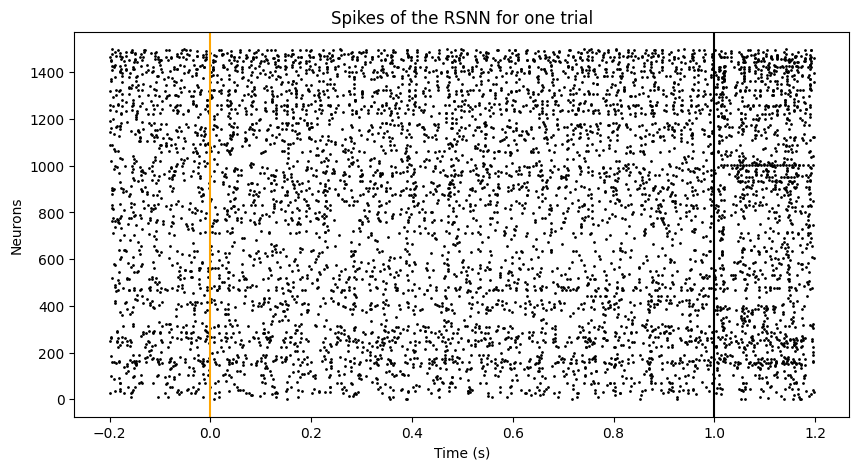

In [4]:
# here we plot the spikes of the neurons of the RSNN for one trial
plt.figure(figsize=(10, 5))
time = torch.arange(0, spikes.shape[1])*0.002 # time vector
sptms, sptns = torch.where(spikes[:,0] == 1) # indices of the spikes
plt.scatter(sptms*0.002-0.2, sptns, s=1, c="k")
plt.xlabel("Time (s)")
plt.ylabel("Neurons")
plt.title("Spikes of the RSNN for one trial")
plt.axvline(0, color="orange")
plt.axvline(1, color="k")
plt.savefig("spikes.png", dpi=300, bbox_inches="tight")